In [15]:
from evaluate import load_pickle, split_data
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

n_calib = 10000
max_valid = 50000

batch_size = 128
num_worker = 4
alpha = 0.1
ts = True
seed = None
use_softmax = True

file_name = '/home/royhirsch/conformal/data/embeds_n_logits/imnet1k_r152/valid.pickle'
# file_name = '/home/royhirsch/conformal/data/imagenet-resnet152.pickle'

data = load_pickle(file_name)
valid_data, calib_data = split_data(data, n_calib, seed=0)

logits = calib_data['preds']
labels = calib_data['labels']
n = len(labels)


In [18]:
# get conformal score
cal_labels = calib_data['labels']
cal_smx = softmax(calib_data['preds'], 1)

val_labels = valid_data['labels']
val_smx = softmax(valid_data['preds'], 1)

# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
    range(n), cal_labels
]
# Get the score quantile
qhat = np.quantile(
    cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
)
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

prediction_sets[np.arange(len(val_labels)), val_labels].mean(), prediction_sets.sum(1).mean(), qhat


/tmp/ipykernel_467789/4139050955.py:15: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(


(0.901775, 216.20455, 0.8679275)

In [19]:
randomized = True
no_zero_size_sets = True

# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
cal_softmax_correct_class = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
    range(n), cal_labels
]
if not randomized:
  cal_scores = cal_softmax_correct_class
else:
  cumsum_index = np.where(cal_srt == cal_softmax_correct_class[:,None])[1]
  high = cal_softmax_correct_class
  low = np.zeros_like(high)
  low[cumsum_index != 0] = cal_srt[np.where(cumsum_index != 0)[0], cumsum_index[cumsum_index != 0]-1]
  cal_scores = np.random.uniform(low=low, high=high)

# Get the score quantile
qhat = np.quantile(
    cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
)
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
if not randomized:
  prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)
else:
  n_val = val_srt.shape[0]
  cumsum_index = np.sum(val_srt <= qhat, axis=1)
  high = val_srt[np.arange(n_val), cumsum_index]
  low = np.zeros_like(high)
  low[cumsum_index > 0] = val_srt[np.arange(n_val), cumsum_index-1][cumsum_index > 0]
  prob = (qhat - low)/(high - low)
  rv = np.random.binomial(1,prob,size=(n_val))
  randomized_threshold = low
  randomized_threshold[rv == 1] = high[rv == 1]
  if no_zero_size_sets:
    randomized_threshold = np.maximum(randomized_threshold, val_srt[:,0])
  prediction_sets = np.take_along_axis(val_srt <= randomized_threshold[:,None], val_pi.argsort(axis=1), axis=1)

prediction_sets[np.arange(len(val_labels)), val_labels].mean(), prediction_sets.sum(1).mean(), qhat


/tmp/ipykernel_467789/2833214419.py:20: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(


(0.9465, 27.083475, 0.7508953704146676)

In [39]:
prediction_sets.shape

(30000, 1000)

In [24]:
def platt_logits(logits, labels, max_iters=10, lr=0.01, epsilon=0.01):
    calib_dataset = torch.utils.data.TensorDataset(torch.from_numpy(logits),
                                                   torch.from_numpy(labels).long()) 
    calib_loader = torch.utils.data.DataLoader(calib_dataset,
                                               batch_size=64,
                                               shuffle=False, pin_memory=True)

    nll_criterion = nn.CrossEntropyLoss().cuda()

    T = nn.Parameter(torch.Tensor([1.3]).cuda())

    optimizer = optim.SGD([T], lr=lr)
    for iter in range(max_iters):
        T_old = T.item()
        for x, targets in calib_loader:
            optimizer.zero_grad()
            x = x.cuda()
            x.requires_grad = True
            out = x/T
            loss = nll_criterion(out, targets.long().cuda())
            loss.backward()
            optimizer.step()
        if abs(T_old - T.item()) < epsilon:
            break
    return T.item() 

t = platt_logits(logits, labels)
print(t)
t = 1.


-4578.80224609375


In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

# calibrate
if use_softmax:
    probs = softmax(logits / t, 1)
else:
    probs = logits
    
scores = []
for p, l in zip(probs, labels):
    true_class_prob = p[l]
    inds = np.where(p >= true_class_prob)[0]
    if len(inds):
        scores.append(p[inds].sum())
    else:
        print('Warning! empty set')

scores = np.asarray(scores)
sorted_scores = np.sort(scores)
qhat = sorted_scores[int(np.ceil((n+1)*(1-alpha)))]
q_level = np.ceil((n+1)*(1-alpha))/n
qhat_q = np.quantile(scores, q_level, interpolation="higher")
print(qhat, qhat_q)

0.004224595261632634 0.004224595261632634


/tmp/ipykernel_455822/2694760229.py:24: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat_q = np.quantile(scores, q_level, interpolation="higher")


In [26]:
def get_score_for_qhat(logits, qhat):
    sl = np.sort(logits)[::-1]
    sl_ind = np.argsort(logits)[::-1]
    i = np.where(np.cumsum(sl) >= qhat)[0][0] + 1
    return logits[sl_ind[:i]].sum(), i + 1

cal_scores = []
set_sizes = []
val_logits = softmax(valid_data['preds'] / t, 1)
for l in val_logits:
    score, size = get_score_for_qhat(l, qhat)
    cal_scores.append(score)
    set_sizes.append(size)
np.asarray(set_sizes).mean()

1001.0

In [13]:
#####
# other calib and predict
#####

def conformal_calibration_logits(calib_loader, T=1., alpha=.1, randomized=True, allow_zero_sets=True):
    with torch.no_grad():
        E = np.array([])
        for logits, targets in calib_loader:
            logits = logits.detach().cpu().numpy()

            scores = softmax(logits/T, axis=1)

            I, ordered, cumsum = sort_sum(scores)

            E = np.concatenate((E,giq(scores,targets,I=I,ordered=ordered,cumsum=cumsum ,randomized=randomized, allow_zero_sets=allow_zero_sets)))
            
        Qhat = np.quantile(E,1-alpha,interpolation='higher')

        return Qhat, E 


def sort_sum(scores):
    I = scores.argsort(axis=1)[:,::-1]
    ordered = np.sort(scores,axis=1)[:,::-1]
    cumsum = np.cumsum(ordered,axis=1) 
    return I, ordered, cumsum


def giq(scores, targets, I, ordered, cumsum, randomized, allow_zero_sets):
    """
        Generalized inverse quantile conformity score function.
        E from equation (7) in Romano, Sesia, Candes.  Find the minimum tau in [0, 1] such that the correct label enters.
    """
    E = -np.ones((scores.shape[0],))
    for i in range(scores.shape[0]):
        E[i] = get_tau(scores[i:i+1,:],targets[i].item(),I[i:i+1,:],ordered[i:i+1,:],cumsum[i:i+1,:],randomized=randomized, allow_zero_sets=allow_zero_sets)

    return E


def gcq(scores, tau, I, ordered, cumsum, randomized, allow_zero_sets):
    sizes_base = ((cumsum) <= tau).sum(axis=1) + 1  # 1 - 1001
    sizes_base = np.minimum(sizes_base, scores.shape[1]) # 1-1000

    if randomized:
        V = np.zeros(sizes_base.shape)
        for i in range(sizes_base.shape[0]):
            V[i] = 1/ordered[i,sizes_base[i]-1] * \
                    (tau-(cumsum[i,sizes_base[i]-1]-ordered[i,sizes_base[i]-1])) # -1 since sizes_base \in {1,...,1000}.

        sizes = sizes_base - (np.random.random(V.shape) >= V).astype(int)
    else:
        sizes = sizes_base

    if tau == 1.0:
        sizes[:] = cumsum.shape[1] # always predict max size if alpha==0. (Avoids numerical error.)

    if not allow_zero_sets:
        sizes[sizes == 0] = 1 # allow the user the option to never have empty sets (will lead to incorrect coverage if 1-alpha < model's top-1 accuracy

    S = list()

    # Construct S from equation (5)
    for i in range(I.shape[0]):
        S = S + [I[i,0:sizes[i]],]

    return S


# Get the 'p-value'
def get_tau(score, target, I, ordered, cumsum, randomized, allow_zero_sets): # For one example
    idx = np.where(I==target)
    tau_nonrandom = cumsum[idx]

    if not randomized:
        return tau_nonrandom
    
    U = np.random.random()

    if idx == (0,0):
        if not allow_zero_sets:
            return tau_nonrandom
        else:
            return U * tau_nonrandom
    else:
        return U * ordered[idx] + cumsum[(idx[0],idx[1]-1)]

randomized=True
allow_zero_sets = True
t = platt_logits(logits, labels)
print(t)

calib_dataset = torch.utils.data.TensorDataset(torch.from_numpy(logits),
                                                torch.from_numpy(labels).long()) 
calib_loader = torch.utils.data.DataLoader(calib_dataset,
                                            batch_size=64,
                                            shuffle=False, pin_memory=True)
qhat, scores = conformal_calibration_logits(calib_loader, t, alpha, randomized, allow_zero_sets)
print(qhat)

val_logits = valid_data['preds'][:max_valid, :]
val_labels = valid_data['labels'][:max_valid]

# calibrate
if use_softmax:
    val_probs = softmax(val_logits / t , 1)
else:
    val_probs = val_logits

I, ordered, cumsum = sort_sum(val_probs)
S = gcq(val_probs, qhat, I=I, ordered=ordered, cumsum=cumsum, randomized=randomized, allow_zero_sets=allow_zero_sets)
np.asarray([len(s) for s in S]).mean()

0.807633101940155


/tmp/ipykernel_351466/3026817442.py:17: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Qhat = np.quantile(E,1-alpha,interpolation='higher')


0.9082633256912231


16.2947

17.110733333333332

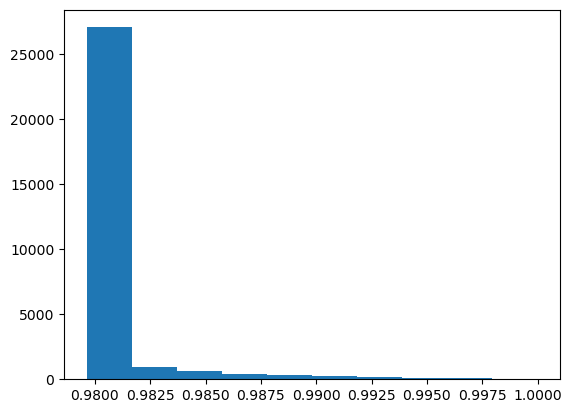

In [12]:
_ = plt.hist(cal_scores)

In [64]:
set_sizes = []
for l, q in zip(val_logits, cal_scores):
    sl = np.sort(l)[::-1]
    sl_ind = np.argsort(l)[::-1]
    i = np.where(np.cumsum(sl) >= q)[0][0] + 1
    set_sizes.append(i)
np.asarray(set_sizes).mean()


15.147666666666666

In [41]:
logits[0][527] + logits[0][742] + logits[0][526] + logits[0][664] + logits[0][782] + logits[0][673]

0.9189198

In [11]:
# eval
total = 0
correct = 0
set_size = []
for s, l in zip(S, val_labels):
    total += 1
    if l in s:
        correct += 1
    set_size.append(len(s))
acc = correct / float(total)
set_size = np.asarray(set_size)

print('Acc: {:.4f}'.format(acc))
print('Set size: {:.2f} ({:.2f})'.format(set_size.mean(), set_size.std()))


Acc: 0.9013
Set size: 16.01 (62.96)


In [5]:
# predict
val_logits = valid_data['preds'][:max_valid, :]
val_labels = valid_data['labels'][:max_valid]

# calibrate
if use_softmax:
    val_probs = softmax(val_logits / t , 1)
else:
    val_probs = val_logits

valid_sets = []
for p, l in zip(val_probs, val_labels):
    sorted_p = np.sort(p)[::-1]
    argsort_p = np.argsort(p)[::-1]
    cumsum_p = np.cumsum(sorted_p)
    inds = np.where(cumsum_p >= qhat)[0]
    if len(inds):
        min_ind = inds[0] + 1
    else:
        print('Warning! empty set')
    valid_sets.append(argsort_p[:min_ind])

# eval
total = 0
correct = 0
set_size = []
for s, l in zip(valid_sets, val_labels):
    total += 1
    if l in s:
        correct += 1
    set_size.append(len(s))
acc = correct / float(total)
set_size = np.asarray(set_size)

print('Acc: {:.4f}'.format(acc))
print('Set size: {:.2f} ({:.2f})'.format(set_size.mean(), set_size.std()))


Acc: 0.9945
Set size: 278.65 (224.19)


In [15]:
cal_pi = probs.argsort(1)[:,::-1]
cal_srt = np.take_along_axis(probs,cal_pi,axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),labels]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
print(qhat)

max_valid = 10000
val_probs = valid_data['preds'][:max_valid, :]
val_labels = valid_data['labels'][:max_valid]

val_pi = val_probs.argsort(1)[:,::-1]
val_srt = np.take_along_axis(val_probs,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)

/tmp/ipykernel_123976/3148427887.py:5: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


0.97921854


In [16]:
# eval
total = 0
correct = 0
set_size = []
for s, l in zip(prediction_sets, val_labels):
    s = np.where(s)[0]
    total += 1
    if l in s:
        correct += 1
    set_size.append(len(s))
acc = correct / float(total)
set_size = np.asarray(set_size)

print('Acc: {:.4f}'.format(acc))
print('Set size: {:.2f} ({:.2f})'.format(set_size.mean(), set_size.std()))


Acc: 0.0000
Set size: 1.76 (0.72)


Acc: 0.0000
Set size: 1.76 (0.72)


In [6]:
probs[np.arange(len(probs)), labels].mean(), scores.mean()


(0.76051396, 0.8952444)

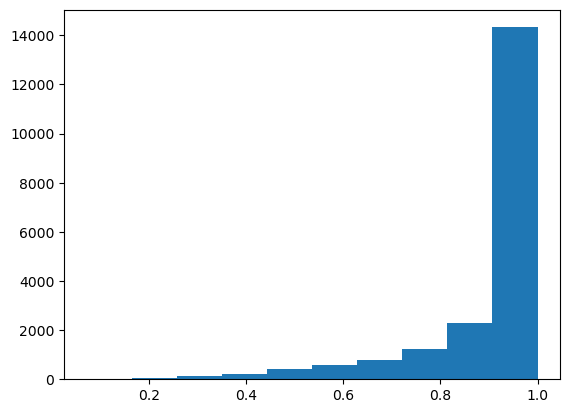

In [7]:
_ = plt.hist(scores)

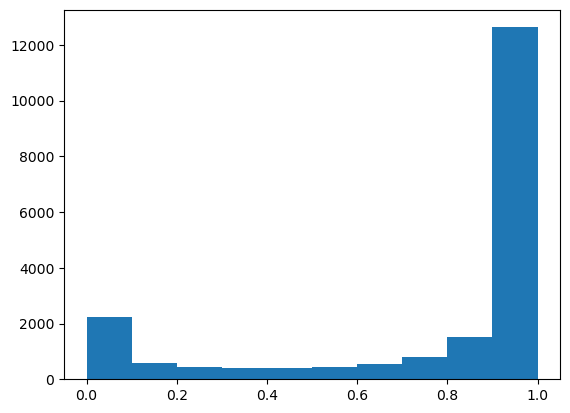

In [8]:
_ = plt.hist(probs[np.arange(len(probs)), labels])

In [3]:
import os
import pickle
import numpy as np
from scipy.special import softmax

import torch
import torch.nn as nn
import torch.optim as optim

from evaluate import load_pickle, split_data
from conf_tools import get_logits_dataloader, platt_logits


def get_conformal_score(logits, labels, t=1.):
    scores = []
    inds = []
    probs = softmax(logits / t, 1)
    for p, l in zip(probs, labels):
        true_class_p = p[l]
        sorted_p = np.sort(p)[::-1]
        # argsort_p = np.argsort(p)[::-1]
        i = np.where(sorted_p == true_class_p)[0] + 1
        score = sorted_p[:int(i)].sum()
        inds.append(i)
        scores.append(score)
    return np.asarray(scores), np.asarray(inds)

def get_dataloader(embeds, scores, labels, batch_size=64, shuffle=False, pin_memory=True):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(embeds),
                                            torch.from_numpy(scores),
                                            torch.from_numpy(labels).long()) 
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             pin_memory=pin_memory)
    return dataloader



num_train = 40000
alpha = 0.1
file_name = '/home/royhirsch/conformal/data/embeds_n_logits/imnet1k_r152/valid.pickle'
plat_scaling = False

data = load_pickle(file_name)
valid_data, train_data = split_data(data, num_train, seed=0)

if plat_scaling:
    train_dataloader = get_logits_dataloader(train_data['preds'], train_data['labels'])
    t = platt_logits(train_dataloader)
else: 
    t = 1.
train_scores, train_inds = get_conformal_score(train_data['preds'], train_data['labels'], t)
train_dl = get_dataloader(train_data['embeds'], np.asarray(train_scores), train_data['labels'], batch_size=64, shuffle=False, pin_memory=True)

valid_scores, valid_inds = get_conformal_score(valid_data['preds'], valid_data['labels'], t)
valid_dl = get_dataloader(valid_data['embeds'], np.asarray(valid_scores), valid_data['labels'], batch_size=64, shuffle=False, pin_memory=True)
print('/')

/


(0.73133737, 0.72836316)

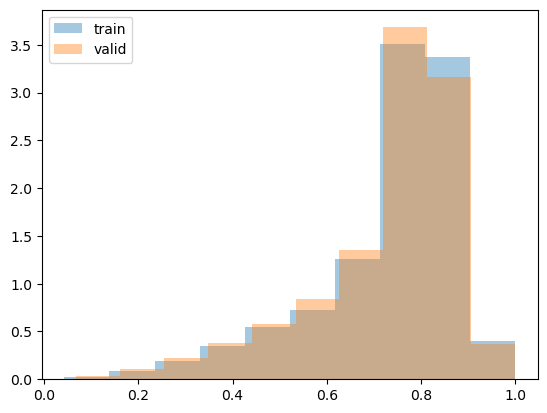

In [2]:
import matplotlib.pyplot as plt
plt.hist(train_scores, label='train', alpha=0.4, density=True)
plt.hist(valid_scores, label='valid', alpha=0.4, density=True)
plt.legend()

train_scores.mean(), valid_scores.mean()

(3.030525, 2.8822)

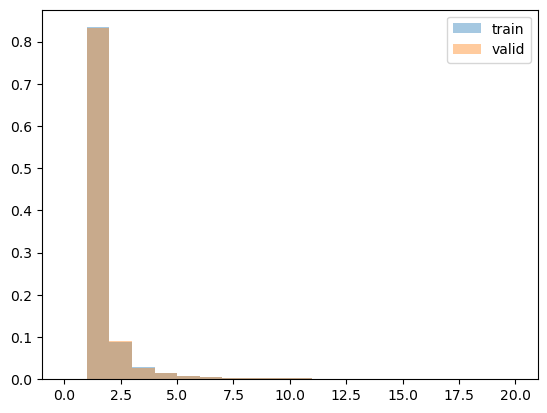

In [9]:
plt.hist(train_inds, bins=20, range=[0,20], label='train', alpha=0.4, density=True)
plt.hist(valid_inds, bins=20, range=[0,20], label='valid', alpha=0.4, density=True)
plt.legend()

train_inds.mean(), valid_inds.mean()